In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

from sklearn import neural_network
from sklearn import metrics
from sklearn.model_selection import train_test_split

import time
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Cats and dogs competition

In the following two notebooks, we will explore Kaggle's famous Dogs vs. Cats competition ( https://www.kaggle.com/c/dogs-vs-cats ). The objective of the competition is to build an algorithm that can distinguish a cat from a dog, given an input .jpeg image. The dataset is divided in the folders

* dataset
 * /train
     * /cats
     * /dogs
  * /test
      * /cats
      * /dogs
      
and consists of a total ot 9600 labeled images of cats and dogs.

In [2]:
train_set = os.listdir('dataset/train/cats') + os.listdir('dataset/train/dogs')
test_set = os.listdir('dataset/test/cats') + os.listdir('dataset/test/dogs')

### The cutest cat in the dataset

(A sample example of image in a dataset). Try and show different cats and dogs in the dataset and pick the cutest one.

In [3]:
imgGray=cv2.imread('dataset/train/cats/cat.3.jpg',0)

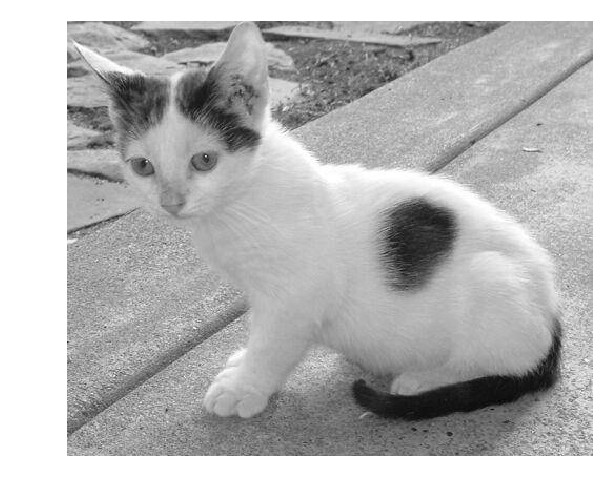

In [4]:
plt.imshow(imgGray, cmap='gray');
plt.axis('off');

# Classification after equalization and resizing
### Resizes the image and extract the classes for the train set

The following loop iterates through the list of images, resizes it to square images of size (target,target), flattens the vector and extracts the classes. The numpy vector classes contains the labels (0 for cats and 1 for dogs) and the features matrix contains the flattened images (each row has size target^2 (why?) ).

In [5]:
target = 35

features_train = np.zeros([len(train_set), target ** 2])
classes_train = np.zeros(len(train_set))

for i in range(len(train_set)):
    animal = train_set[i]
    if 'cat' in animal:
        classes_train[i] = 0
        img = cv2.imread('dataset/train/cats/' + animal, 0)
    elif 'dog' in animal:
        classes_train[i] = 1
        img = cv2.imread('dataset/train/dogs/' + animal, 0)

    res = cv2.resize(img, (target, target))
    
    features_train[i] = res.reshape(-1) / 256

### And the same for the test set


In [6]:
target = 35

features_test = np.zeros([len(test_set), target ** 2])
classes_test = np.zeros(len(test_set))

for i in range(len(test_set)):
    animal = test_set[i]
    if 'cat' in animal:
        classes_test[i] = 0
        img = cv2.imread('dataset/test/cats/' + animal, 0)
    elif 'dog' in animal:
        classes_test[i] = 1
        img = cv2.imread('dataset/test/dogs/' + animal, 0)

    res = cv2.resize(img, (target, target))
    
    features_test[i] = res.reshape(-1) / 256

### "Centering" images

Subtracts the average and divide by the standard deviation of these column. These transformation usually give a better performance when working with neural networks.

In [7]:
av=np.mean(features_train,axis=0)
features_train -= av

In [8]:
std = np.std(features_train,axis=0)
features_train /= std

## One-Hidden-Layer Neural Network on Centered/Normalized Input Bits

By default the neural newtork of sklearn uses the "log-loss" (or "cross-entropy") function as objective function for the classifier. This function is "finer" than accuracy (i.e., simply counting the number of correct classes). Assume that we only have two classes labeled as '0' or '1' and that our algorithm estimates the probability that the output is equal to $1$. Given the correct classes $y_i$ (0 or 1) and the estimated probability $\hat{y}_i$ , the log loss function is

$$\text{log_loss} = -\frac{1}{N} \sum_{i=0}^N y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).$$

($0 \log 0 = 0$ by definition). Can you make sense of the log loss function? If not, ask Jan.

In [14]:
model = neural_network.MLPClassifier(hidden_layer_sizes=[1200],verbose=True)

In [15]:
start=time.time()
model.fit(features_train, classes_train)
end=time.time()
print(end-start)

Iteration 1, loss = 0.89985334
Iteration 2, loss = 0.70971416
Iteration 3, loss = 0.57229413
Iteration 4, loss = 0.72432968
Iteration 5, loss = 0.54495814
Iteration 6, loss = 0.50192902
Iteration 7, loss = 0.46547592
Iteration 8, loss = 0.44916473
Iteration 9, loss = 0.48491530
Iteration 10, loss = 0.49778022
Iteration 11, loss = 0.39924752
Iteration 12, loss = 0.53718813
Iteration 13, loss = 0.38983227
Iteration 14, loss = 0.32674898
Iteration 15, loss = 0.37637309
Iteration 16, loss = 0.50283793
Iteration 17, loss = 0.42364653
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
66.40793585777283


### Calculating the accuracy and log loss of the model in the test set and showing a sample prediction

Remember that we have transfomed the training set by subtracting the average and dividing by the standard deviation. In order to make a correct prediction, before predicting we need to apply these transformations to the test set

In [16]:
predicted_classes = model.predict((features_test-av)/std)
predicted_probabilities = model.predict_proba((features_test-av)/std)

accuracy = metrics.accuracy_score(classes_test, predicted_classes)
log_loss = metrics.log_loss(classes_test,predicted_probabilities)

cm = metrics.confusion_matrix(classes_test, predicted_classes)
print('accuracy: '+str(accuracy)+' logloss= '+str(log_loss))
print('confusionMatrix:')
print(cm/len(classes_test))

accuracy: 0.614583333333 logloss= 0.833966072604
confusionMatrix:
[[ 0.3         0.2       ]
 [ 0.18541667  0.31458333]]


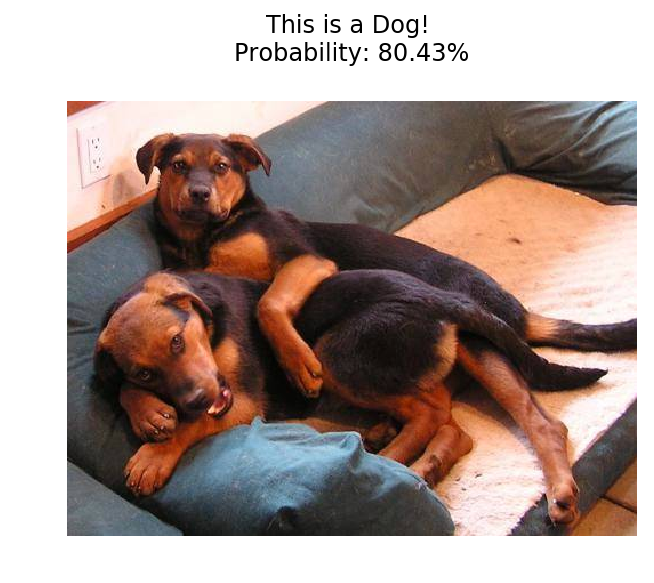

In [33]:
i = np.random.randint(len(test_set))

dic = {0:'Cat',1:'Dog'} 

animal = test_set[i]
if 'cat' in animal:
    testRGB = cv2.imread('dataset/test/cats/'+animal)
elif 'dog' in animal:
    testRGB = cv2.imread('dataset/test/dogs/'+animal)

testRGB = cv2.cvtColor(testRGB, cv2.COLOR_BGR2RGB)
    
image_to_predict = ((features_test[i]-av)/std).reshape(1,-1)

pred=model.predict_proba(image_to_predict)[0,0]

plt.title('This is a '+dic[pred<0.5]+'! \nProbability: '+str(round(100*((1-pred)*(pred<0.5)+pred*(pred>0.5)),2))+'%\n')
plt.imshow(testRGB);
plt.axis('off');

## Conclusions 

Neural Nets with one hidden layer in the raw bits is NOT good for this task :) (but of course better than Logistic Regression). The best cross-validation accuracy achieved was around 61%. 

## See for yourself

Does increasing the image size improve the performance? Is the change significant? Try and change the number/size of hidden layers. What are the parameters that gave you the best accuracy? 

## To think:

Does a better accuracy necessarily imply a better (smaller) log loss?

## Dodging the log-loss function

The following piece of code gives a better log-loss function, but the accuracy and confusion matrices remain the same: can you tell why?

In [22]:
predicted_classes = model.predict((X_test-av)/std)
predicted_probabilities = np.clip(model.predict_proba((X_test-av)/std), 0.35, 0.65)


accuracy = metrics.accuracy_score(y_test, predicted_classes)
log_loss = metrics.log_loss(y_test,predicted_probabilities)

cm = metrics.confusion_matrix(y_test, predicted_classes)
print('accuracy: '+str(accuracy)+' logloss= '+str(log_loss))
print('confusionMatrix:')
print(cm/len(X_test))


accuracy: 0.614743856726 logloss= 0.664343688858
confusionMatrix:
[[ 0.32069971  0.18492295]
 [ 0.20033319  0.29404415]]
